In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import os,sys
import utils
import matplotlib.pyplot as plt
from numpy import array
from multiprocessing import Pool
import multiprocessing as mp
from consts import sensor_lat as lat
from consts import sensor_log as log
from consts import valid_sensor_res_10 as valid_sensor_list
from consts import valid_sensor_res_10_old as valid_sensor_list_old
from consts import sensor_day_seconds as day_seconds
from consts import sensor_week_seconds as week_seconds 
from consts import sensor_start_time_unix as start_time
from consts import sensor_end_time_unix as end_time
from consts import sensor_epoch_length as epoch_length
from consts import sensor_optimal_time_interval as optimal_time_interval
from consts import sensor_loc_pic as loc_pic
from consts import sensor_drop_list as drop_list
import consts
import time
import pickle
import copy

In [11]:
df = pd.read_hdf('optimal.h5')
time_stamp = np.arange(start_time,end_time+optimal_time_interval,optimal_time_interval)
unix_column = 'Time since the epoch [s]'
idd = 'Station ID'
a_temperature = 'Ambient Temperature'
s_temperature = 'Surface Temperature'

In [168]:
def remove_duplicated(df,drop_list=drop_list):
    '''剔除dataframe中的重复项，以Station ID为基准'''
    # sub_df = df[-df.isna()]
    sub_df = df.dropna()
    sub_df = sub_df[-sub_df[idd].duplicated()]
    for i in drop_list:
        sub_df = sub_df[-(sub_df[idd] == i)]
    return sub_df

In [169]:
def dataframe_to_matrix(df,loc=loc_pic,drop_list=drop_list):
    temper = np.copy(loc)
    # print(temper)
    temper = temper.reshape(100)
    for i in range(len(temper)):
        if int(temper[i]) != 0 and int(temper[i]) not in drop_list:
            v = df[df[idd] == temper[i]][a_temperature].values
            index = df[df[idd] == temper[i]].index.tolist()
            # print(temper[i],v)
            if len(v) == 1 and np.isnan(v[0]) == False:
                # print(v[0])
                temper[i] = v[0]
            else:
                temper[i] = 0
            # print(index)
            # print(df.loc(index,a_temperature))
        else:
            temper[i] = 0
    temper = temper.reshape(10,10)
    # print(temper)
    return temper

In [38]:
sub_df_list = []
for i in range(len(time_stamp)-1):
    sub_df = df[(df[unix_column] >= time_stamp[i]) & (df[unix_column] < time_stamp[i+1])]
    sub_df_list.append(sub_df)

In [171]:
# 原版输出optimal 子序列的方法
sub_df_list_optimal = []
for item in sub_df_list:
    if len(remove_duplicated(item)) == 44:
        sub_df_list_optimal.append(item)
print(len(sub_df_list_optimal))

5959


In [252]:
# 增加optimal 与 时间对应关系的df
sub_df_list_optimal = []
sub_df_list_optimal_index = []
for i,item in enumerate(sub_df_list):
    if(len(remove_duplicated(item))== 44):
        sub_df_list_optimal.append(item)
        sub_df_list_optimal_index.append(i)
print(len(sub_df_list_optimal))
print(len(sub_df_list_optimal_index))

5959


In [228]:
rb_sub_df_list_optimal = []
for item in sub_df_list_optimal:
    uniq_df = remove_duplicated(item)
    rb_sub_df_list_optimal.append(uniq_df)
print(len(rb_sub_df_list_optimal)) 

5959


In [176]:
len(sub_df_list_optimal)

5959

In [170]:
len(valid_sensor_list_old)-len(drop_list)

44

In [173]:
#查看3913 中有多少有效数据
nan_count = np.zeros(len(sub_df_list_optimal))
for i,item in enumerate(sub_df_list_optimal):
    uniq_df = remove_duplicated(item)
    lens = uniq_df.isna().sum().sum()
    nan_count[i] += lens

In [174]:
for i,j in enumerate(nan_count):
    if j != 0:
        print(i)

In [136]:
drop_df_list_optimal = []
for item in sub_df_list_optimal:
    drop_df_list_optimal.append(item.drop(df.columns[-1],axis=1))

In [179]:
df1 = remove_duplicated(sub_df_list_optimal[3])
df2 = sub_df_list_optimal[3]

In [167]:
drop_list = [7, 27, 47,63, 55, 73,82] #73
# sensor_drop_list = [7,27,47,63,82,88]

In [184]:
data_matrix_list = []
for item in sub_df_list_optimal:
    tmp = dataframe_to_matrix(item)
    data_matrix_list.append(tmp)
print(len(data_matrix_list))

5959


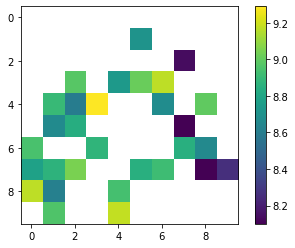

In [202]:
plt.imshow(convert_nan(data_matrix_list[0]))
plt.colorbar()

In [229]:
a_temperature_mean = []
a_temperature_std =[]
for item in rb_sub_df_list_optimal:
    a_temperature_mean.append(item[a_temperature].mean())
    a_temperature_std.append(item[a_temperature].std())
print(len(a_temperature_mean))
print(len(a_temperature_std))

5959
5959


In [247]:
a_temperature_array_std = []
for i,item in enumerate(rb_sub_df_list_optimal):
    tmp = item[a_temperature]-a_temperature_mean[i]
    tmp = tmp/a_temperature_std[i]
    a_temperature_array_std.append(tmp)
a_temperature_array_std = np.array(a_temperature_array_std)
print(len(a_temperature_array_std))

5959


In [248]:
a_temperature_array = []
for item in rb_sub_df_list_optimal:
    a_temperature_array.append(item[a_temperature])
a_temperature_array = np.array(a_temperature_array)
print(len(a_temperature_array))

5959


In [251]:
a00 = a_temperature_array[0]
a11 = a_temperature_array[1]
print(a00)
print(a11)

[8.2  8.84 8.73 8.71 8.1  8.5  8.34 8.85 7.96 8.68 9.12 9.17 8.14 8.76
 8.67 8.74 9.02 8.1  8.9  8.68 9.29 8.66 8.58 8.6  8.88 8.65 9.   8.34
 8.87 9.06 8.95 8.62 8.81 8.96 8.26 9.05 8.85 9.18 8.92 8.78 8.94 9.17
 8.98 8.3 ]
[7.94 8.82 8.76 8.57 7.91 8.34 8.18 8.58 7.91 8.4  9.12 9.18 7.88 8.76
 8.64 8.72 9.01 7.96 8.88 8.8  9.2  8.48 8.5  8.58 8.94 8.72 8.98 8.24
 8.66 8.98 8.77 8.54 8.68 8.91 8.1  9.   8.72 9.03 8.82 8.74 8.83 9.28
 8.92 8.22]


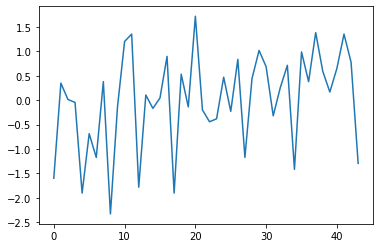

In [244]:
plt.plot(a_temperature_array[0])

In [269]:
print(sub_df_list_optimal_index[0])
print(sub_df_list_optimal_index[1])
print(time_stamp[11])
print(time_stamp[13])

2
9
1172703930
1172703990


In [268]:
sub_df_list_optimal_index[2]
# sub_df_list_optimal_index[3]

11

In [274]:
print(a_temperature_array[2])
print(a_temperature_array[3])

[7.9  8.87 8.72 8.54 7.9  8.31 8.24 8.52 7.86 8.32 9.06 9.17 7.86 8.68
 8.54 8.76 8.95 7.96 8.82 8.78 9.2  8.52 8.58 8.6  8.88 8.69 8.93 8.22
 8.64 8.9  8.74 8.59 8.63 9.   8.05 8.96 8.8  9.   8.91 8.64 8.72 9.28
 8.86 8.25]
[7.9  8.94 8.74 8.52 8.06 8.38 8.27 8.45 7.96 8.25 9.04 9.15 7.96 8.66
 8.5  8.78 8.94 8.04 8.74 8.85 9.24 8.47 8.54 8.66 8.85 8.73 8.9  8.38
 8.58 8.86 8.71 8.59 8.7  8.99 7.99 8.94 8.75 8.84 8.96 8.6  8.7  9.26
 8.82 8.27]


In [271]:
a0 = a_temperature_array[2]
a1 = a_temperature_array[3]
print(abs(a0-a1))

[0.   0.07 0.02 0.02 0.16 0.07 0.03 0.07 0.1  0.07 0.02 0.02 0.1  0.02
 0.04 0.02 0.01 0.08 0.08 0.07 0.04 0.05 0.04 0.06 0.03 0.04 0.03 0.16
 0.06 0.04 0.03 0.   0.07 0.01 0.06 0.02 0.05 0.16 0.05 0.04 0.02 0.02
 0.04 0.02]


In [246]:
a0 = a_temperature_array[2]
a1 = a_temperature_array[3]
print(a0-a1)

[ 0.13798931 -0.23791641 -0.06784846  0.07908568 -0.31918985 -0.13637176
 -0.00938389  0.22558076 -0.14049447  0.2618467  -0.01520578 -0.03515205
 -0.14049447  0.05369951  0.13623307 -0.07510165 -0.02383321 -0.10148005
  0.19975553 -0.22159673 -0.21203413  0.16843336  0.12897988 -0.16038368
  0.04600727 -0.11955597  0.03694078 -0.37721536  0.17524749  0.07095437
  0.07139343  0.0128718  -0.19439727 -0.0328997   0.28223203  0.00292719
  0.11766104  0.39570576 -0.1880222   0.1181001   0.04644632 -0.05509832
  0.07820756  0.01737651]


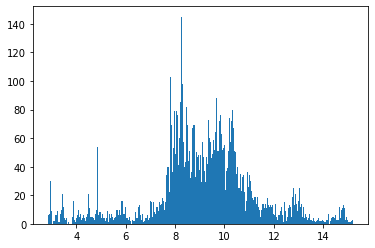

In [230]:
_,_,_ = plt.hist(a_temperature_mean,bins=300)

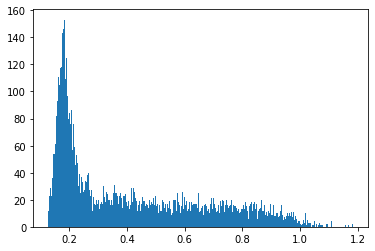

In [233]:
_,_,_ = plt.hist(a_temperature_std,bins=300)

In [203]:
nan_data_matrix_list =[]
for item in data_matrix_list:
    nan_data_matrix_list.append(convert_nan(item))
print(len(nan_data_matrix_list))

5959


In [201]:
def convert_nan(temper):
    for i in range(len(temper)):
        for j in range(len(temper)):
            if temper[i][j] == 0:
                temper[i][j] = np.nan
    return temper

In [60]:
nan_count = np.zeros(len(sub_df_list_optimal))
for i,item in enumerate(sub_df_list_optimal):
    nan_count[i]=(item.isna().sum().sum())

In [177]:
nan_sum = 0
for i in nan_count:
    if i == 0:
        nan_sum +=1

In [30]:
dataframe_to_matrix(df1)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 8.77, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 8.32, 7.88, 0.  , 0.  ],
       [0.  , 0.  , 8.94, 0.  , 8.79, 9.04, 9.18, 0.  , 0.  , 0.  ],
       [0.  , 8.91, 8.66, 9.3 , 0.  , 0.  , 8.73, 0.  , 8.96, 0.  ],
       [0.  , 8.72, 8.84, 0.  , 0.  , 0.  , 0.  , 8.11, 0.  , 0.  ],
       [9.04, 9.12, 8.88, 8.87, 0.  , 0.  , 0.  , 8.88, 8.74, 0.  ],
       [8.83, 8.95, 9.1 , 0.  , 0.  , 8.91, 8.96, 0.  , 8.15, 8.28],
       [9.28, 8.66, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 9.01, 0.  , 0.  , 9.14, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [33]:
dataframe_to_matrix(df1)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 8.68, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 8.28, 8.05, 0.  , 0.  ],
       [0.  , 0.  , 8.94, 0.  , 8.72, 9.  , 9.15, 0.  , 0.  , 0.  ],
       [0.  , 8.86, 8.62, 9.26, 0.  , 0.  , 8.65, 0.  , 8.96, 0.  ],
       [0.  , 8.68, 0.  , 0.  , 0.  , 0.  , 0.  , 8.08, 0.  , 0.  ],
       [8.92, 9.06, 8.92, 8.95, 0.  , 0.  , 0.  , 8.87, 8.6 , 0.  ],
       [8.82, 8.82, 9.04, 0.  , 0.  , 8.92, 8.9 , 0.  , 8.06, 8.21],
       [9.26, 8.62, 0.  , 0.  , 8.9 , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 9.06, 0.  , 0.  , 9.24, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [16]:
print(time_stamp[1],time_stamp[0])

1172703630 1172703600


## 更新drop_list，其原始数据如下

In [96]:
print("index\tlength\tnan\tratio")
for item in valid_sensor_list_old:
    length = len(df[df[idd] == item])
    nan = df[df[idd]==item].isna().sum().sum()
    print("{}\t{}\t{}\t{}\t".format(item,length,nan,nan/length))

index	length	nan	ratio
7	0	0	nan	
8	19540	9	0.00046059365404298874	
11	19581	0	0.0	
14	19658	0	0.0	
17	19675	0	0.0	
19	19810	0	0.0	
23	19553	0	0.0	
26	19653	0	0.0	
27	0	0	nan	
31	19348	0	0.0	
33	19759	0	0.0	
34	19761	0	0.0	
35	19594	0	0.0	
40	19420	0	0.0	
46	19703	0	0.0	
47	0	0	nan	
49	18280	0	0.0	
51	19685	0	0.0	
55	18856	12913	0.6848218073822656	
57	19753	0	0.0	
59	16503	0	0.0	
60	19207	0	0.0	
61	19607	0	0.0	
62	19053	0	0.0	
63	13017	0	0.0	
65	19729	0	0.0	
69	19832	0	0.0	
70	19668	0	0.0	
71	19557	0	0.0	
72	18927	0	0.0	
73	19588	3654	0.1865427812946702	
75	19584	0	0.0	
76	19802	0	0.0	
79	16125	0	0.0	
80	19683	222	0.01127876848041457	
81	19239	2	0.0001039555070429856	
82	4077	17	0.004169732646553839	
84	18686	0	0.0	
87	19035	59	0.0030995534541633832	
88	19174	59	0.0030770835506414938	
89	19709	1	5.073824141255264e-05	
93	19430	0	0.0	
96	19693	0	0.0	
97	19603	0	0.0	
98	19700	48	0.002436548223350254	
100	19732	0	0.0	
103	19608	51	0.0026009791921664627	
104	17604	0	0.0	
109	19659	0	0.0	
1

## 存储数据集到hdf5

In [275]:
import h5py

In [277]:
f = h5py.File('dataset.hdf5','w')

In [283]:
print(type(a_temperature_array))
print(a_temperature_array.shape)

<class 'numpy.ndarray'>
(5959, 44)


In [299]:
dset = f.create_dataset("a_temperature_array",data=a_temperature_array)

In [286]:
print(type(rb_sub_df_list_optimal))
print(len(rb_sub_df_list_optimal))
print(type(rb_sub_df_list_optimal[0]))

<class 'list'>
5959
<class 'pandas.core.frame.DataFrame'>


In [312]:
print(type(sub_df_list_optimal))
print(len(sub_df_list_optimal))
print(len(sub_df_list))
print(type(sub_df_list))

<class 'list'>
5959
20160
<class 'list'>


In [334]:
df_dict = {'rb_optimal':5959,'optimal':5959,'df_list':20160}

In [338]:
for key in df_dict:
    print(key,df_dict[key])

rb_optimal 5959
optimal 5959
df_list 20160


In [352]:
dataset_write(rb_sub_df_list_optimal,'rb_optimal')

In [369]:
dataset_write(sub_df_list_optimal,'optimal')

In [370]:
dataset_write(sub_df_list,'df_list')

In [ ]:
re = dataset_read('rb_optimal')

In [348]:
# 已废弃，磁盘IO性能差
def dataset_write1(data_list,key,df_dict=df_dict):
    filename = key+'.h5'
    for i,item in enumerate(data_list):
        item.to_hdf(filename,key=key+'_'+str(i))

In [371]:
def dataset_write(data_list,key,df_dict=df_dict):
    filename = 'ds_'+key+'.h5'
    store = pd.HDFStore(filename)
    for i,item in enumerate(data_list):
        store[key+'_'+str(i)] = item
    store.close()
    return 1

In [368]:
def dataset_read(key,df_dict=df_dict):
    filename = 'ds_'+key+'.h5'
    return_list = []
    store = pd.HDFStore(filename)
    for i in range(df_dict[key]):
        return_list.append(store[key+'_'+str(i)])
    store.close()
    return return_list

In [294]:
print(type(sub_df_list_optimal_index))
print(len(sub_df_list_optimal_index))
print(type(time_stamp))
print(time_stamp.shape)
f.create_dataset('sub_df_list_optimal_index',data=sub_df_list_optimal_index)
f.create_dataset('time_stamp',data=time_stamp)

<class 'list'>
5959
<class 'numpy.ndarray'>
(20161,)


In [364]:
f.keys()

<KeysViewHDF5 ['a_temperature_array', 'a_temperature_mean', 'a_temperature_std', 'sub_df_list_optimal_index', 'time_stamp']>

In [332]:
print(type(a_temperature_mean))
print(len(a_temperature_mean))
print(type(a_temperature_std))
print(len(a_temperature_std))
f.create_dataset('a_temperature_mean',data=a_temperature_mean)
f.create_dataset('a_temperature_std',data=a_temperature_std)

<class 'list'>
5959
<class 'list'>
5959


<HDF5 dataset "a_temperature_std": shape (5959,), type "<f8">

In [365]:
f.close()